# Market Simulator
ML for trading Udacity Course exercise

More info:
http://wiki.quantsoftware.org/index.php?title=CompInvesti_Homework_3

A transcription of the Udacity Course lectures can be find on https://docs.google.com/document/d/1ELqlnuTSdc9-MDHOkV0uvSY4RmI1eslyQlU9DgOY_jc/edit?usp=sharing

Kairoart 2018
"""


## Overview

In this project you will create a basic market simulator that accepts trading orders and keeps track of a portfolio's value and saves it to a file. You will also create another program that assesses the performance of that portfolio. 

## Part 1: Create a market simulation tool

Starting cash: 1000000  
Input file: orders.csv 
Output file: values.csv

The file of orders is organized like this:

    Year
    Month
    Day
    Symbol
    BUY or SELL
    Number of Shares 
    
For example:

    2008, 12, 3, AAPL, BUY, 130
    2008, 12, 8, AAPL, SELL, 130
    2008, 12, 5, IBM, BUY, 50


### Goal

Your simulator should calculate the total value of the portfolio for each day using adjusted closing prices (cash plus value of equities) and print the result to the file values.csv. The contents of the values.csv file should look something like this:

    2008, 12, 3, 1000000
    2008, 12, 4, 1000010
    2008, 12, 5, 1000250
    ...


### Import libraries

In [861]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import sys
import csv

# To fetch data
from pandas_datareader import data as pdr   
import fix_yahoo_finance as yf  
yf.pdr_override()   

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



### Read orders from file

In [862]:
def readOrdersFileIntoDF(filename):

    # opening the filename
    fr = open(filename)
    
    # for row count in 
    index=0
    
    # Lists used for making the dataframe.
    dtList = []
    symbolList = []
    orderTypeList = []
    volumeList = []
    
    # For each line
    # A Sample Line - 2011,1,14,AAPL,Buy,1500
    for orderString in fr.readlines():

        # Stripping off the return line character
        orderString=orderString.strip()
        
        # Splitting the line and getting a List back
        listFromLine = orderString.split(',')
        
        # Adding the dates into dtList. 16,00,00 for 1600 hrs
        dtList.append(dt.datetime(int(listFromLine[0]), int(listFromLine[1]), int(listFromLine[2])))
        
        # Adding the symbols into symbolList
        symbolList.append(listFromLine[3])
        
        # Adding the orders into orderTypeList
        orderTypeList.append(listFromLine[4])
        
        # Adding the number of shares into volumeList
        volumeList.append(listFromLine[5])

    # Creating a Dictionary for converting it into DataFrame later
    data = { 'datetime' : dtList, 'symbol' : symbolList, 'ordertype':orderTypeList, 'volume':volumeList }

    # Converting the Dictinary into a nice looking Pandas Dataframe ordered by datetime index
    ordersDataFrame = pd.DataFrame(data)
    ordersDataFrame.index= ordersDataFrame['datetime']
    
    # Drop datetime column
    ordersDataFrame.drop('datetime', axis=1, inplace=True)
    #print(ordersDataFrame)
    
    
    # Getting the Symbols from the Orders. This list will be required for fetching the prices
    symbolList = list(set(ordersDataFrame['symbol']))
    
    # Returning it.
    return ordersDataFrame, symbolList

### Get data from Yahoo for the dates 

In [909]:
def fetchData(dt_start, dt_end, ls_symbols):
    print(dt_start, dt_end)
    print(ls_symbols)
    # Add a day to dt_end for Yahoo purpose
    dt_end = pd.to_datetime(dt_end) + pd.DateOffset(days=1)
    
    # Get data of trading days between the start and the end.
    df = pdr.get_data_yahoo(ls_symbols, dt_start, dt_end)       
    nan_rows = df.isnull().sum().sum()
    #df.info()
    #print(df)

    # Getting the numpy ndarray of Adj Close prices.
    na_price = pd.DataFrame(df['Adj Close'].values)
    
    # Adding symbols as column names
    na_price.columns = ls_symbols
    
    # Setting index to na_price
    na_price.index = df.index
    
    # returning the Adj Closed prices for all the days    
    return na_price

### Market simulator

In [882]:
def marketsim(initialCash, ordersdf, symbols):

    # reading the boundary dates
    dt_start = ordersdf.index[0]
    dt_end = ordersdf.index[len(ordersdf)-1]
    
    # All the adjustedClosingPrices fetched from NYSE within the range and for given symbols
    closingPrices = fetchData(dt_start, dt_end, symbols)
    num_tradingDays = len(closingPrices)
   
    # For Holdings of the share
    temp = np.zeros((1, len(symbols)))
    holdings = pd.DataFrame(temp, columns = symbols, index = ['holdings'])
    
    #Cash for the days
    temp = np.zeros((num_tradingDays, 1))
    cash = pd.DataFrame(temp, columns = ['cashinhand'])
    
    #Value for the days
    temp = np.zeros((num_tradingDays, 1))
    valueFrame = pd.DataFrame(temp, columns = ['valueOfPortfolio'])

    #Setting the first value to be the initial cash amount.
    cash.cashinhand.loc[0] = initialCash
    
    index = 0
    
    for tradingDayIndex in range(num_tradingDays):  
        if tradingDayIndex != 0:
            cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex - 1] 
        else:
            cash.cashinhand.iloc[tradingDayIndex] = initialCash
            
        for tradingOrder in ordersDataFrame.index:
            if tradingOrder == closingPrices.index[tradingDayIndex]:
                if ordersdf.ordertype.iloc[index] == 'Buy':
                    toBuySymbol = ordersdf.symbol.iloc[index]
                    toBuy = symbols.index(toBuySymbol)
                    numShares = ordersdf.volume.iloc[index]
                    priceForTheDay = closingPrices.iloc[tradingDayIndex][toBuy]
                    cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex] - (priceForTheDay * float(numShares))
                    holdings[toBuySymbol].iloc[0] += int(numShares)
                    print("Date: ", tradingOrder,
                          "Symbol: ", toBuySymbol,
                          "Order: ", ordersdf.ordertype.iloc[index],
                          "Shares: ", numShares,
                          "Price: ", priceForTheDay,
                          "Cash: ", cash.cashinhand.iloc[tradingDayIndex] )
                elif ordersdf.ordertype.iloc[index] == 'Sell':
                    toSellSymbol = ordersdf.symbol.iloc[index]
                    toSell = symbols.index(toSellSymbol)
                    numShares = ordersdf.volume.iloc[index]
                    priceForTheDay = closingPrices.iloc[tradingDayIndex][toSell]
                    cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex] + (priceForTheDay * float(numShares))
                    holdings[toSellSymbol].iloc[0] -= int(numShares)
                    print("Date: ", tradingOrder,
                          "Symbol: ", toSellSymbol,
                          "Order: ", ordersdf.ordertype.iloc[index],
                          "Shares: ", numShares,
                          "Price: ", priceForTheDay,
                          "Cash: ", cash.cashinhand.iloc[tradingDayIndex] )
                else:
                    print("error")
                index+=1
        

        valueFrame['cashinhand'] = cash['cashinhand'].values
        
    valueFrame.index = closingPrices.index
    return valueFrame

### Write values to file

In [885]:
def writeValuesIntoCSV(valuesFilename, valueFrame):
    file = open(valuesFilename, 'w')
    writer = csv.writer(file)
    for index in range(len(valueFrame)):
        writer.writerow([valueFrame.index[index].year, valueFrame.index[index].month, valueFrame.index[index].day ,int(round(valueFrame.cashinhand.iloc[index], 0))])
    
    file.close()

### Define initial values and execute simulation

In [886]:
initialCash = 1000000
ordersFilename = 'input/orders.csv'
valuesFilename = 'output/values.csv'

# Reading the data from the file, and getting a NumPy matrix
ordersDataFrame, symbols = readOrdersFileIntoDF(ordersFilename)

# Getting data from marketsim
valueFrame = marketsim(initialCash, ordersDataFrame, symbols)

# Writing data to file
writeValuesIntoCSV(valuesFilename, valueFrame)

2011-01-10 00:00:00 2011-12-20 00:00:00
[*********************100%***********************]  4 of 4 downloaded
Date:  2011-01-10 00:00:00 Symbol:  AAPL Order:  Buy Shares:  1500 Price:  116.94583100000001 Cash:  824581.2535
Date:  2011-01-13 00:00:00 Symbol:  AAPL Order:  Sell Shares:  1500 Price:  117.880554 Cash:  1001402.0845
Date:  2011-01-13 00:00:00 Symbol:  IBM Order:  Buy Shares:  4000 Price:  43.765831 Cash:  826338.7605
Date:  2011-01-26 00:00:00 Symbol:  GOOG Order:  Buy Shares:  1000 Price:  62.682235999999996 Cash:  763656.5244999999
Date:  2011-02-02 00:00:00 Symbol:  XOM Order:  Sell Shares:  4000 Price:  304.02261400000003 Cash:  1979746.9805
Date:  2011-02-10 00:00:00 Symbol:  XOM Order:  Buy Shares:  4000 Price:  306.228271 Cash:  754833.8965
Date:  2011-03-03 00:00:00 Symbol:  GOOG Order:  Sell Shares:  1000 Price:  67.885254 Cash:  822719.1505
Date:  2011-03-03 00:00:00 Symbol:  IBM Order:  Sell Shares:  2200 Price:  45.523163000000004 Cash:  922870.1091
Date:  2011-

In [881]:
#valueFrame['cashinhand'] = cash['cashinhand'].values
valueFrame.head(15)
#valueFrame.info()

,valueOfPortfolio,cashinhand
Date,,
2011-01-10,824581.2535,824581.2535
2011-01-11,824581.2535,824581.2535
2011-01-12,824581.2535,824581.2535
2011-01-13,826338.7605,826338.7605
2011-01-14,826338.7605,826338.7605
2011-01-18,826338.7605,826338.7605
2011-01-19,826338.7605,826338.7605
2011-01-20,826338.7605,826338.7605
2011-01-21,826338.7605,826338.7605


## Part 2: Create a portfolio analysis tool

The tool should read in the daily values (cumulative portfolio value) from values.csv and plot them. It should use the symbol on the command line as a benchmark for comparison (in this case $SPX). Using this information, it should:

    * Plot the price history over the trading period.
    * Your program should also output:
        * Standard deviation of daily returns of the total portfolio
        * Average daily return of the total portfolio
        * Sharpe ratio (Always assume you have 252 trading days in an year. And risk free rate = 0) of the total portfolio
        * Cumulative return of the total portfolio 


### Read cumulative portfolio values

In [887]:
def readValuesFileIntoDF(filename):

    # opening the filename
    fr = open(filename)
    
    # for row count in 
    index=0
    
    # Lists used for making the dataframe.
    # Date list    
    dtList = []
    
    # Cumulative values list
    cvList = []
    
    # For each line
    # A Sample Line - 2011,1,14,AAPL,Buy,1500
    for orderString in fr.readlines():

        # Stripping off the return line character
        orderString=orderString.strip()
        
        # Splitting the line and getting a List back
        listFromLine = orderString.split(',')
        
        # Adding the dates into dtList.
        dtList.append(dt.datetime(int(listFromLine[0]), int(listFromLine[1]), int(listFromLine[2])))
                
        # Adding the number of shares into volumeList
        cvList.append(listFromLine[3])

    # Creating a Dictionary for converting it into DataFrame later
    data = { 'datetime' : dtList, 'Portfolio Value':cvList }

    # Converting the Dictinary into a nice looking Pandas Dataframe ordered by datetime index
    valuesDataFrame = pd.DataFrame(data)
    valuesDataFrame.index= valuesDataFrame['datetime']
    
    # Drop datetime column
    valuesDataFrame.drop('datetime', axis=1, inplace=True)
    #print(ordersDataFrame)

    
    # Returning it.
    return valuesDataFrame

In [934]:
# Funds values
valuesFilename = 'output/values.csv'
df = readValuesFileIntoDF(valuesFilename)
#print(df.head())


           Portfolio Value
datetime                  
2011-01-10          824581
2011-01-11          824581
2011-01-12          824581
2011-01-13          826339
2011-01-14          826339


### Fecth SPX data for comparison

In [912]:
# reading the boundary dates
dt_start = df.index[0]
dt_end = df.index[len(df)-1]

symbolSPX = ['SPX']
spxValues = fetchData(dt_start, dt_end, symbolSPX)

#print(spxValues)


2011-01-10 00:00:00 2011-12-20 00:00:00
['SPX']
[*********************100%***********************]  1 of 1 downloaded


### Plot portfolio value from values.csv

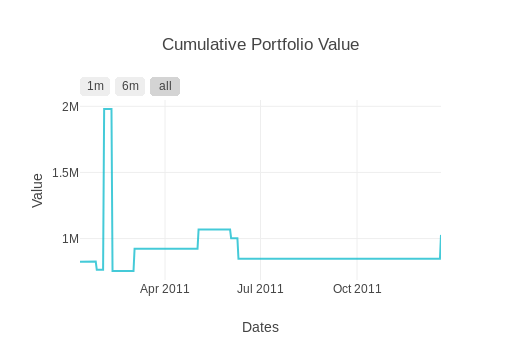

In [915]:


trace_value = go.Scatter(
                x=df.index,
                y=df['Portfolio Value'],
                name = "Portfolio Value",
                line = dict(color = '#17BECF'),
                opacity = 0.8)
trace_dr = go.Scatter(
                x=spxValues.index,
                y=spxValues['SPX'],
                name = "SPX",
                line = dict(color = '#FF8000'),
                opacity = 0.8)
data = [trace_value]

layout = dict(
    title = "Cumulative Portfolio Value",
    xaxis = dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            ),

    yaxis = dict(
            title='Value')

    )



fig = dict(data=data, layout=layout)
iplot(fig)

### Plot the price history over the trading period

In [900]:
# reading the boundary dates
dt_start = df.index[0]
dt_end = df.index[len(df)-1]

# Getting data from Yahoo
values = fetchData(dt_start, dt_end, symbols)
columnNames = list(values.head(0)) 

2011-01-10 00:00:00 2011-12-20 00:00:00
['IBM', 'XOM', 'AAPL', 'GOOG']
[*********************100%***********************]  4 of 4 downloaded


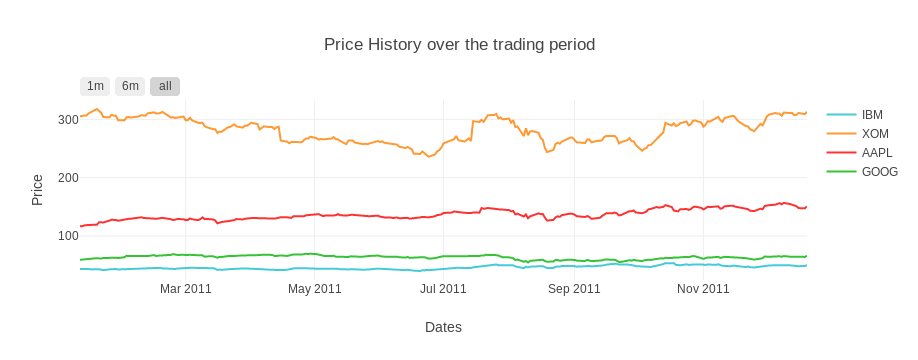

In [919]:

trace_price1 = go.Scatter(
                x=df.index,
                y=values.iloc[:,0],
                name = columnNames[0],
                line = dict(color = '#17BECF'),
                opacity = 0.8)
trace_price2 = go.Scatter(
                x=df.index,
                y=values.iloc[:,1],
                name = columnNames[1],
                line = dict(color = '#FF8000'),
                opacity = 0.8)
trace_price3 = go.Scatter(
                x=df.index,
                y=values.iloc[:,2],
                name = columnNames[2],
                line = dict(color = '#FF0000'),
                opacity = 0.8)

trace_price4 = go.Scatter(
                x=df.index,
                y=values.iloc[:,3],
                name = columnNames[3],
                line = dict(color = '#04B404'),
                opacity = 0.8)
data = [trace_price1, trace_price2, trace_price3, trace_price4]

layout = dict(
    title = "Price History over the trading period",
    xaxis = dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            ),

    yaxis = dict(
            title='Price')

    )



fig = dict(data=data, layout=layout)
iplot(fig)

### Standard deviation of daily returns of the total portfolio 

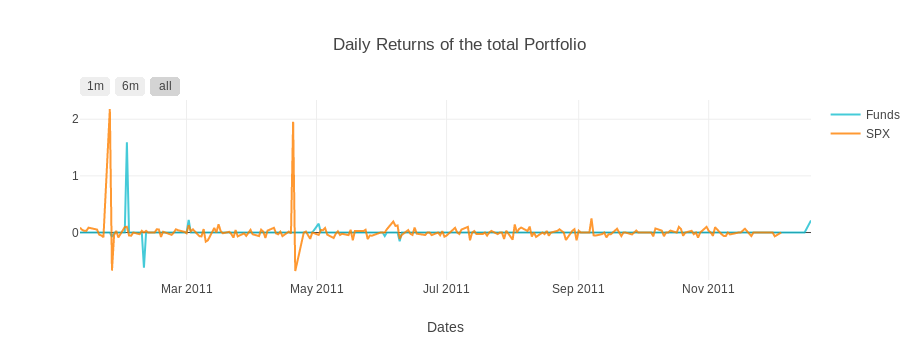

In [947]:
# Get daily portfolio value
valuesFilename = 'output/values.csv'
df = readValuesFileIntoDF(valuesFilename)

# Convert string to number
df['Portfolio Value'] = pd.to_numeric(df['Portfolio Value'], errors='coerce')
portf_value = pd.Series(df['Portfolio Value'])


# Daily returns funds
daily_rets = portf_value.pct_change(1)
daily_rets = daily_rets[1:]  

# daily returns normedSPX
daily_rets_SPX = spxValues.pct_change()
daily_rets_SPX = daily_rets_SPX[1:]

trace_daily_rets = go.Scatter(
                x=df.index,
                y=daily_rets,
                name = "Funds",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_daily_rets_SPX = go.Scatter(
                x=df.index,
                y=daily_rets_SPX['SPX'],
                name = "SPX",
                line = dict(color = '#FF8000'),
                opacity = 0.8)

data = [trace_daily_rets, trace_daily_rets_SPX]

layout = dict(
    title = "Daily Returns of the total Portfolio",
    xaxis = dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            ),

    yaxis = dict(
            title='')

    )



fig = dict(data=data, layout=layout)
iplot(fig)

# Standar deviation daily return
stddevPort = daily_rets.std()

# Standar deviation SPX daily return
stddevSPX = daily_rets_SPX.std()



### Average daily return of the total portfolio 

In [932]:
# Averrage daily returns
adr = daily_rets.mean()

## Results

In [940]:
print("The final value of the portfolio using the sample file is ", df.index[-1], " ", df['Portfolio Value'].iloc[-1])
print("Details of the Performance of the portfolio")
print("")

print("Data Range :", dt_start ," to ", dt_end)

print("")

print("Sharpe Ratio of Fund :", sharpeRatioPort)
print("Sharpe Ratio of $SPX :", sharpeRatioSPX)
print("")

print("Total Return of Fund :", totalPortRet)
print("Total Return of $SPX :", totalSPXRet)

print("")

print("Standard Deviation of Fund :", stddevPort)
print("Standard Deviation of $SPX :", stddevSPX)

print("")

print("Average Daily Return of Fund :", averagePortfolioDailyRets)
print("Average Daily Return of $SPX :", averageSPXDailyRets)

The final value of the portfolio using the sample file is  2011-12-20 00:00:00   1027696
Details of the Performance of the portfolio

Data Range : 2011-01-10 00:00:00  to  2011-12-20 00:00:00



NameError: name 'sharpeRatioPort' is not defined